<a href="https://colab.research.google.com/github/iabiala/Machine-Learning-projects/blob/main/QlearningGym_Blackjack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
from collections import defaultdict
import gymnasium as gym
import numpy as np

class BlackjackAgent:
  def __init__(
      self,
      env: gym.Env,
      learning_rate: float,
      initial_epsilon: float,
      epsilon_decay: float,
      final_epsilon: float,
      discount_factor: float = 0.95,
  ):


  ### Initialize a Q-learning environment

   ### Args:
       ### env: the training environment
       ### learning_rate: how quickly to update the Q-values
       ### initial_epsilon: Starting exploration rate (usually 1.0)
       ### epsilon_decay: How much to reduce epsilon each episode
       ### final_epsilon: Minimum exploration rate (usually 0.1)
       ### discount_factor: How much to value future rewards (0-1)

    self.env = env

    # Q-table: maps (state, action) to expected reward
    # defaultdict automatically creates entries with zeros for new states

    self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
    self.lr = learning_rate
    self.discount_factor = discount_factor

    # Exploration parameters
    self.epsilon = initial_epsilon
    self.epsilon_decay = epsilon_decay
    self.final_epsilon = final_epsilon

    # Track learning progress
    self.training_error = []

  def get_action(self, obs: tuple[int, int, bool]) -> int:
    # Choose an action using epsilon-greedy strategy

    # Returns:
            # action: 0 (stand) or 1 (hit)

    # With probability epsilon: explore (random action)

    if np.random.random() < self.epsilon:
      return self.env.action_space.sample()

    # with probability (1 - epsilon) exploit best action
    else:
      return int(np.argmax(self.q_values[obs]))


  def update(
      self,
      obs: tuple[int, int, bool],
      action: int,
      reward: float,
      terminated: bool,
      next_obs: tuple[int, int, bool],):

    future_q_value = (not terminated) * np.max(self.q_values[next_obs])

    # What should the Q-value be? (Bellman equation)
    target = reward + self.discount_factor * future_q_value

    # How wrong was our current estimate?
    temporal_difference = target - self.q_values[obs][action]

    # Update our estimate in the direction of the error
    # Learning rate controls how big steps we take
    self.q_values[obs][action] = (self.q_values[obs][action] + self.lr * temporal_difference)

    # Track learning progress
    self.training_error.append(temporal_difference)

  def decay_epsilon(self):
    # Reduce exploration rate after each episode
    self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)



# Current estimate: Q(state, action)
current_q = self.q_values[obs][action]

# What we actually experienced: reward + discounted future value
target = reward + self.discount_factor * max(self.q_values[next_obs])

# How wrong were we?
error = target - current_q

# Update estimate: move toward the target
new_q = current_q + learning_rate * error

**Training the Agent**

In [39]:
# Training hyperparameters
learning_rate = 0.01
n_episodes = 100
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)
final_epsilon = 0.1


# Create environment and agent
env = gym.make('Blackjack-v1', sab=False)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)


agent = BlackjackAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [40]:
from tqdm import tqdm # Progress bar

for episode in tqdm(range(n_episodes)):
  # Start a new hand
  obs, info = env.reset()
  done = False

  # Play one complete hand
  while not done:
    # Agent chooses action (initially random, gradually more intelligent)
    action = agent.get_action(obs)

    # Take action and observe result
    next_obs, reward, terminated, truncated, info = env.step(action)

    # Learn from this experience
    agent.update(obs, action, reward, terminated, next_obs)

    # Move to next state
    done = terminated or truncated
    obs = next_obs

  # Reduce exploration rate (agent becomes less random over time)
  agent.decay_epsilon()

100%|██████████| 100/100 [00:00<00:00, 6339.45it/s]


**Visualizing the Training Results**

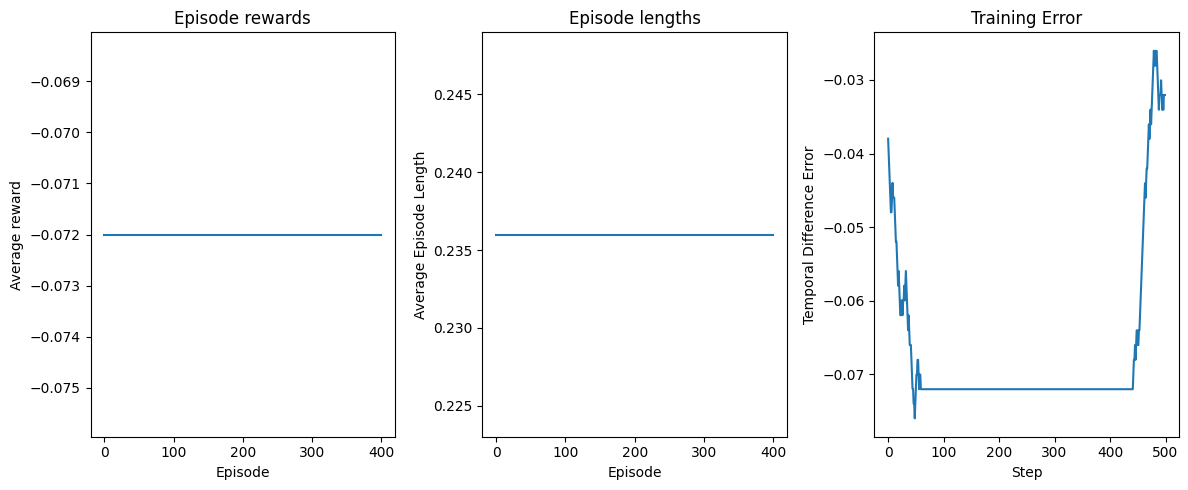

In [42]:
from matplotlib import pyplot as plt

def get_moving_avgs(arr, window, convolution_mode):
  """ Compute moving average to smooth noisy data. """

  return np.convolve(
      np.array(arr).flatten(),
      np.ones(window),
      mode=convolution_mode
  ) / window

# Smooth over a 500-episode window
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

# Episode rewards (win/loss performance)
axs[0].set_title('Episode rewards')
reward_moving_average = get_moving_avgs(
    env.return_queue,
    rolling_length,
    "valid"
)

axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[0].set_ylabel("Average reward")
axs[0].set_xlabel("Episode")

# Episode lengths (how many actions per hand)
axs[1].set_title("Episode lengths")
length_moving_average = get_moving_avgs(
    env.length_queue,
    rolling_length,
    "valid"
)

axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[1].set_ylabel("Average Episode Length")
axs[1].set_xlabel("Episode")

# Training error (how much we're still learning)
axs[2].set_title("Training Error")
training_error_moving_average = get_moving_avgs(
    agent.training_error,
    rolling_length,
    "same"
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
axs[2].set_ylabel("Temporal Difference Error")
axs[2].set_xlabel("Step")

plt.tight_layout()
plt.show()


